In [1]:
import numpy as np
import freegs
from freegs.machine import MirroredCoil, Solenoid, Wall
from freegs import optimise as opt

In [2]:
PR1 = 0.50738376
PZ1 = 0.39384023
PR2 = 0.62576723
PZ2 = 0.1996288

In [3]:
poloidal_coils = [
    ('PF1', MirroredCoil(PR1, PZ1, turns=4)),
    ('PF2', MirroredCoil(PR2, PZ2, turns=4))
]

In [4]:
solenoid_height = 0.94
inner_radius = 51e-3
outer_radius = 60e-3
solenoid_turns = 104
central_solenoid = [("SOL", Solenoid((inner_radius + outer_radius) / 2, -solenoid_height / 2, solenoid_height / 2,
                                     solenoid_turns, control=True))]

In [5]:
R0 = 0.28     # Middle of the circle
rwall = 0.12 # Radius of the circular wall

npoints = 200 # Number of points on the wall

# Poloidal angles
thetas = np.linspace(0, 2*np.pi, npoints, endpoint=False)

# Points on the wall
Rwalls = R0 + rwall * np.cos(thetas)
Zwalls = rwall * np.sin(thetas)

walls = Wall (
    Rwalls,
    Zwalls
)

In [6]:
tokamak = freegs.machine.Machine(
    central_solenoid + poloidal_coils,
    walls
)

In [7]:
tokamak['PF1']['U'].area = tokamak['PF1']['L'].area = tokamak['PF2']['U'].area = tokamak['PF2']['L'].area = 0.000213825*4

In [8]:
eq = freegs.Equilibrium(tokamak=tokamak,
                        Rmin=0.01, Rmax=0.6,    # Radial domain
                        Zmin=-0.5, Zmax=0.5,   # Height range
                        nx=65, ny=65          # Number of grid points
                        )

In [9]:
plasma_major_radius = 0.28
toroidal_magnetic_field_strength_at_plasma_centre = 0.875
vacuum_toroidal_magnetic_field = plasma_major_radius * toroidal_magnetic_field_strength_at_plasma_centre

In [10]:
profiles = freegs.jtor.ConstrainBetapIp(eq,
                                        0.05, # Plasma poloidal beta
                                        3e3, # Plasma current [Amps]
                                        vacuum_toroidal_magnetic_field) # Vacuum f=R*Bt

In [11]:
xpoints = [(0.28, -0.24), (0.28, 0.24)]  # (R,Z) locations of X-points
isoflux = [(0.28, -0.24, 0.28, 0.24)]  # (R1,Z1, R2,Z2) pairs
constrain = freegs.control.constrain(isoflux=isoflux, xpoints=xpoints)

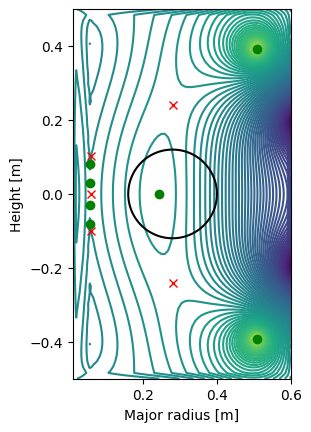

psi_relchange: 0.11421940228312674
bndry_relchange: 0.002
bndry_change: inf

psi_relchange: 0.10424131429729384
bndry_relchange: 1.0
bndry_change: 1.9928367772055373e-06


/home/roy/DataspellProjects/AtomCraft_Plasma_Modelling/pf_coil_optimisation/freegs/jtor.py:222: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  shapeintegral, _ = quad(


psi_relchange: 0.011260036355926133
bndry_relchange: 1.012112570277331
bndry_change: -0.00016651917029497147

psi_relchange: 0.009977754377458216
bndry_relchange: 0.09544223796202107
bndry_change: 1.4334632106057128e-05

psi_relchange: 0.007964948355502
bndry_relchange: 0.15134840648188516
bndry_change: -2.6785167021524034e-05

psi_relchange: 0.005982787278266713
bndry_relchange: 0.017089045720000796
bndry_change: -3.0769478993684495e-06

psi_relchange: 0.004382811144644826
bndry_relchange: 0.01186101414696809
bndry_change: -2.16125554533501e-06

psi_relchange: 0.003208975918509354
bndry_relchange: 0.008442305714990484
bndry_change: -1.5514128441933468e-06

psi_relchange: 0.0023218513553894845
bndry_relchange: 0.006150264112433493
bndry_change: -1.1372065366050787e-06

psi_relchange: 0.0016706506784682918
bndry_relchange: 0.004426128134681387
bndry_change: -8.220459106197205e-07

psi_relchange: 0.0012043668257796876
bndry_relchange: 0.0031597714987571996
bndry_change: -5.88711083395713

In [12]:
freegs.solve(eq,
             profiles,
             constrain,
             show=True,
             check_limited=False,
             limit_it=0
             )

Updating coil R:0.51 Z:0.39
Updating coil R:0.63 Z:0.20
Updating coil R:0.51 Z:0.39
Updating coil R:0.63 Z:0.20
Updating coil R:0.50 Z:0.39
Updating coil R:0.63 Z:0.20
Updating coil R:0.50 Z:0.39
Updating coil R:0.63 Z:0.20
Updating coil R:0.50 Z:0.39
Updating coil R:0.63 Z:0.20
Updating coil R:0.50 Z:0.40
Updating coil R:0.63 Z:0.20
Updating coil R:0.51 Z:0.39
Updating coil R:0.63 Z:0.20
Updating coil R:0.63 Z:0.21
Updating coil R:0.51 Z:0.38
Updating coil R:0.63 Z:0.20
Updating coil R:0.50 Z:0.39
Updating coil R:0.63 Z:0.20


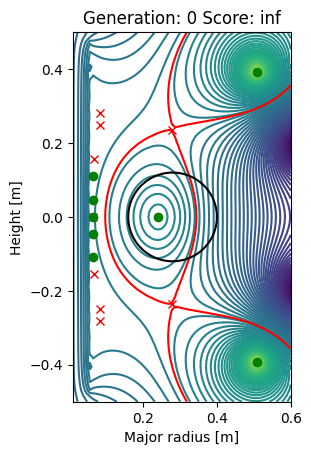

In [13]:
best_eq = opt.optimise(eq,  # Starting equilibrium
                       # List of controls
                       [
                           opt.CoilRadius('PF1'),
                           opt.CoilRadius('PF2'),
                           opt.CoilHeight('PF1'),
                           opt.CoilHeight('PF2')
                       ],
                       # The function to minimise
                       opt.weighted_sum(opt.max_abs_coil_current, opt.no_wall_intersection),
                       N=4,  # Number of solutions in each generation
                       maxgen=1 ,  # How many generations
                       monitor=opt.PlotMonitor())  # Plot the best in each generation

In [14]:
print(
    best_eq.tokamak['PF1']['U'].R - PR1,
    best_eq.tokamak['PF1']['U'].Z - PZ1
)

0.0 0.0


In [15]:
print(
    best_eq.tokamak['PF2']['U'].R - PR2,
    best_eq.tokamak['PF2']['U'].Z - PZ2
)

0.0 0.0
